<a href="https://colab.research.google.com/github/mscholl96/mad-recime/blob/network_CVAE/network/CVAE/cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional variational autoencoder
Variational autoencoder for tabular data, oriented upon: https://lschmiddey.github.io/fastpages_/2021/03/14/tabular-data-variational-autoencoder.html 

Adopted with one hot encoding for tabular data
## Load Json Database of recipes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/2022_03_19/ingredients_complete.pkl'
embeddingPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/vocab.bin'
unitDictPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/2022_03_19/ingredients_unitDict.pkl'
modelOutPath = "/content/drive/MyDrive/TP2/Network/VAE/cvae.pt"
import sys
sys.path.append(dataPath)

In [ ]:
dataPath = 'data/ingredients_complete_2k.pkl'
embeddingPath = 'data/vocab.bin'
unitDictPath = 'data/ingredients_unitDict.pkl'
modelOutPath = 'model/cvae.pt'

In [3]:
import pickle

with open(dataPath, 'rb') as f:
    pklData = pickle.load(f)

print(pklData.keys())
print(len(pklData))

Index(['000033e39b', '000035f7ed', '00003a70b1', '00004320bb', '0000631d90',
       '000075604a', '00007bfd16', '000095fc1d', '0000973574', '0000b1e2b5',
       ...
       'ffff606358', 'ffff70ccee', 'ffff728423', 'ffff72b421', 'ffff7f3e9f',
       'ffff89d1ae', 'ffffbb45d2', 'ffffcd4444', 'ffffd533d7', 'ffffdea29a'],
      dtype='object', name='id', length=834726)
834726


## Convert list of ingredients to pandas dataframe and one hot encode the dataframe.

In [4]:
!pip install word2vec

     |████████████████████████████████| 42 kB 593 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=f9fcc54047d4f9898939452e4454f63d7c051b49bb9ee0a3ec75ae87da7c3196
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [4]:
from src.ReciMePreprocessor import ReciMePreprocessor

preprocessor = ReciMePreprocessor(embeddingPath, unitDictPath)

## VAE
### Setup

In [5]:
# Import pytorch dependencies
import torch
from torch import optim
from torch.utils.data import DataLoader

# Import additional libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Import custom autoencoder
from src.ReciMeEncoder import ReciMeEncoder
from src.ReciMeConditionalEncoder import ReciMeConditionalEncoder

# Import custom helper functions
from src.networkUtils import CustomLoss, DataBuilder, test, train

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Setup Datasets + Hyperparameters

In [6]:
# One hot encoding without embedding and using sparse frame
train_data, test_data =  train_test_split(pklData, test_size=0.3, random_state=42)
batch_size = 256
# Definition of batches
train_builder = DataBuilder(train_data, preprocessor)
test_builder = DataBuilder(test_data, preprocessor)

trainloader=DataLoader(dataset=train_builder, batch_size=batch_size, collate_fn=train_builder.customCollate)
testloader=DataLoader(dataset=test_builder, batch_size=batch_size, collate_fn=test_builder.customCollate)

In [7]:
paramList = [train_builder.customCollate([train_builder[0]]).shape[1], 10000, 8000, 6000, 4000]

model = ReciMeConditionalEncoder(paramList, 300, useBatchNorm=True, actFunc=torch.nn.ReLU(), outFunc=torch.nn.Tanh()).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = CustomLoss()

ReciMeConditionalEncoder(
  (encoderStack): Sequential(
    (0): _BatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=6660, out_features=10000, bias=True)
        (1): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): _BatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=10000, out_features=8000, bias=True)
        (1): BatchNorm1d(8000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): _BatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=8000, out_features=6000, bias=True)
        (1): BatchNorm1d(6000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): _BatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=6000, out_features=4000, bias=True)
        (1): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=Tru

### Train Model

In [8]:
epochs = 100
log_interval = 5
val_losses = []
train_losses = []
train_losses_MSE = []
train_losses_KLD = []
test_losses = []
test_losses_MSE = []
test_losses_KLD = []

In [9]:
for epoch in range(1,epochs+1):
    print(epoch)
    train_return = train(epoch, batch_size, log_interval, model, trainloader, device, optimizer, loss_fn, True)
    train_losses.append(train_return[0])
    train_losses_MSE.append(train_return[1])
    train_losses_KLD.append(train_return[2])
    test_return = test(epoch, batch_size, log_interval, model, testloader, device, optimizer, loss_fn, True)
    test_losses.append(test_return[0])
    test_losses_MSE.append(test_return[1])
    test_losses_KLD.append(test_return[2])
    if epoch % log_interval == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': (train_losses, test_losses),
            }, modelOutPath)

1
2
3
4
5
====> Epoch: 5 Average training loss: 115.03951, MSE: 110.31785, KLD: 4.72166
====> Epoch: 5 Average test loss: 113.3769, MSE: 108.5601, KLD: 4.8168
6
7
8
9
10
====> Epoch: 10 Average training loss: 110.55143, MSE: 105.52672, KLD: 5.02472
====> Epoch: 10 Average test loss: 110.8206, MSE: 105.6948, KLD: 5.1258
11
12
13
14
15
====> Epoch: 15 Average training loss: 109.79049, MSE: 104.70115, KLD: 5.08934
====> Epoch: 15 Average test loss: 110.7047, MSE: 105.8014, KLD: 4.9033
16
17
18
19
20
====> Epoch: 20 Average training loss: 109.27513, MSE: 104.13428, KLD: 5.14085
====> Epoch: 20 Average test loss: 110.7762, MSE: 105.6783, KLD: 5.0979
21
22
23
24
25
====> Epoch: 25 Average training loss: 108.69848, MSE: 103.32346, KLD: 5.37502
====> Epoch: 25 Average test loss: 110.8289, MSE: 105.1516, KLD: 5.6773
26
27
28
29
30
====> Epoch: 30 Average training loss: 107.86274, MSE: 102.06273, KLD: 5.80002
====> Epoch: 30 Average test loss: 110.6565, MSE: 104.9926, KLD: 5.6639
31
32
33
34
35


(0.0, 500.0)

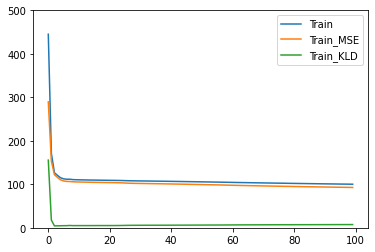

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(train_losses_MSE)
plt.plot(train_losses_KLD)
plt.legend(['Train', 'Train_MSE', 'Train_KLD'])
plt.ylim([0,500])

(0.0, 500.0)

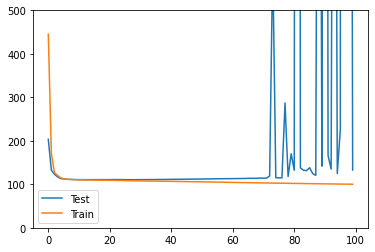

In [11]:
import matplotlib.pyplot as plt
plt.plot(test_losses)
plt.plot(train_losses)
plt.legend(['Test', 'Train'])
plt.ylim([0,500])

In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': (train_losses, test_losses),
    }, "/content/drive/MyDrive/TP2/Network/VAE/cvae_100epoch.pt")

### Draw random samples form latent space and generate new data

In [18]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        optimizer.zero_grad()
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        break

TypeError: ignored

In [ ]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

df = preprocessor.decodeOutput(pred)
df[0]

,amount,unit,ingredient
0,0.046789646,teaspoon,flour
1,0.007748604,teaspoon,sugar
2,1.7422438,teaspoon,baking_powder
3,0.06824732,centimetre,</s>
4,0.06556511,centimetre,eggs
5,0.068843365,centimetre,flour
6,0.08434057,centimetre,flour
7,0.97095966,tablespoon,baking_soda
8,0.035762787,tablespoon,salt
9,0.0834465,teaspoon,salt


In [12]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        optimizer.zero_grad()
        conditional = testloader.dataset.preProcessor.getConditional(data).to(device)
        data = data.to(device)
        recon_batch, mu, logvar = model(data, conditional)
        break

In [47]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 2
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

ingredient_cond = 'flour'

ingredient_cond_words = ingredient_cond.lower().split(" ")
for i in range(len(ingredient_cond_words)):
    name_ind = preprocessor.ingredientDict.get("_".join(ingredient_cond_words[i:]))
    if name_ind:
        ingredient_cond_int = name_ind
        break
ingredient_cond_emb = preprocessor.emb(torch.LongTensor([ingredient_cond_int]*no_samples)).to(device)

with torch.no_grad():
    pred = model.decode(z, ingredient_cond_emb).cpu().numpy()

df = preprocessor.decodeOutput(pred)
df[0]

,amount,unit,ingredient
0,30.009747,,MINUTES
1,13.296604,,empty
2,8.279383,,properly
3,8.434951,,
4,7.9140067,,
5,7.841885,ounce,
6,1.0409951,gram,
7,5.173981,gallon,
8,1.0210276,,
9,0.89615583,cup,
